# u2001820 Powerlifting Project: Battle of the Sexes + Natural or Not?
---
We aim to investigate the powerlifting dataset available on <a href="https://www.kaggle.com/datasets/open-powerlifting/powerlifting-database">Kaggle</a>.

This notebook is dedicated to exploring the differences between males and females in the world of powerlifting.

In [1]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ks_2samp

### Exploring the cleaned dataset

In [2]:
df = pd.read_csv("cleaned_powerlifting.csv")

C:\Users\asale\AppData\Local\Temp\ipykernel_18444\2428485417.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("cleaned_powerlifting.csv")


In [3]:
len(df)

1058986

In [4]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,24-34,F-OR,59.8,60,80.0,...,324.16,286.42,511.15,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,24-34,F-OR,58.5,60,100.0,...,378.07,334.16,595.65,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
2,Amy Moldenhauer,F,SBD,Wraps,23.0,20-23,F-OR,60.0,60,-105.0,...,345.61,305.37,547.04,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
3,Andrea Rowan,F,SBD,Wraps,45.0,45-49,F-OR,104.0,110,120.0,...,338.91,274.56,550.08,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
4,April Alvarez,F,SBD,Wraps,37.0,35-39,F-OR,74.0,75,127.5,...,354.74,312.20,596.18,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup


In [64]:
df_filtered = df[['Name', 'Sex', 'Equipment', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 
               'TotalKg', 'Wilks', 'Tested']]

In [65]:
df_filtered.head()

,Name,Sex,Equipment,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,Tested
0,Abbie Murphy,F,Wraps,59.8,105.0,55.0,130.0,290.0,324.16,NaN
1,Abbie Tuong,F,Wraps,58.5,120.0,67.5,145.0,332.5,378.07,NaN
2,Amy Moldenhauer,F,Wraps,60.0,105.0,72.5,132.5,310.0,345.61,NaN
3,Andrea Rowan,F,Wraps,104.0,140.0,80.0,170.0,390.0,321.25,NaN
4,April Alvarez,F,Wraps,74.0,142.5,82.5,145.0,370.0,354.74,NaN


In [66]:
df_filtered['Equipment'].value_counts()

Equipment
Single-ply    647332
Raw           280202
Wraps         101686
Multi-ply      29766
Name: count, dtype: int64

For simplicity, we consider only contestants competing with `Single-ply`:

In [67]:
df_filtered = df_filtered[df_filtered['Equipment'] == 'Single-ply']

In [68]:
df_filtered.head()

,Name,Sex,Equipment,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,Tested
5157,Nathan Jones,M,Single-ply,109.0,385.0,195.0,330.0,910.0,537.05,NaN
6638,Eric Stockdreher,M,Single-ply,96.1,275.0,170.0,240.0,685.0,423.91,Yes
6639,Patrizia Engeser,F,Single-ply,50.4,85.0,47.5,92.5,225.0,287.30,Yes
6640,Madeleine Melzer,F,Single-ply,50.6,80.0,NaN,90.0,NaN,NaN,Yes
6642,Katja Haindl,F,Single-ply,56.7,100.0,50.0,85.0,235.0,273.82,Yes


In [69]:
df_filtered['Tested'].value_counts()

Tested
Yes    608202
Name: count, dtype: int64

The `Tested` column determines whether the lifter has been tested for drug use or not. There are only two values in present in this column: `Yes` or NaN. In powerlifting, a 'natural' lifter is one who does not use Performance Enhancing Drugs, whereas those who do are referred to as 'enhanced'. Thus, any lifter with the value `Yes` in this column is most certainly a natural lifter, at least when tested in time for the competition. That said, just because a lifter has not been drug tested (value NaN), does not necessarily mean that said lifter is abusing drugs. To guarantee that we are dealing with natural athletes, we filter the data to ensure that `Tested = Yes`. So we now consider the remaining entrants are natural lifters.

In [70]:
df_filtered = df_filtered[df_filtered['Tested'] == 'Yes']

In [71]:
len(df_filtered)

608202

In [72]:
df_filtered['Name'].nunique()

165265

We have competitors with more than one entry in the dataset. This could be due to participants entering multiple competitions, for example. As such, we group records by the unique entrants, aggregating with the mean for their performance metrics in the three lifts:

In [73]:
df_filtered = df_filtered.groupby(['Name','Sex',
                       'Tested'])[['Best3SquatKg','Best3BenchKg',
                       'Best3DeadliftKg','TotalKg','BodyweightKg', 'Wilks']].mean().reset_index()

In [74]:
print(len(df_filtered))
# remove rows with missing values
df_filtered = df_filtered.dropna()
print(len(df_filtered))

165690
154299


In [75]:
df_filtered.head()

,Name,Sex,Tested,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,BodyweightKg,Wilks
0,A Abduzhabarov,M,Yes,155.00,110.00,170.00,435.00,74.00,312.90
1,A Akins,M,Yes,115.67,90.72,129.27,335.66,107.05,199.26
2,A Allmehat,M,Yes,165.00,120.00,170.00,455.00,72.50,332.15
3,A Almeida,F,Yes,45.00,25.00,75.00,145.00,44.00,204.17
4,A Ashwin,M,Yes,180.00,95.00,210.00,485.00,81.70,326.82


We devise our own `WeightClassKg` column to ensure consistency across all records of data:

In [76]:
df_filtered['WeightClassKg'] = df_filtered['BodyweightKg'].apply(float)

def weight_class(x):
    for i in range(10, 140, 10):
        if(x < i):
            return f"{str(i-10).zfill(3)} - {i} kg"
    return "130+ kg"
    
df_filtered['WeightClassKg'] = df_filtered['BodyweightKg'].apply( lambda x: weight_class(x))

In [77]:
df_filtered.head()

,Name,Sex,Tested,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,BodyweightKg,Wilks,WeightClassKg
0,A Abduzhabarov,M,Yes,155.00,110.00,170.00,435.00,74.00,312.90,070 - 80 kg
1,A Akins,M,Yes,115.67,90.72,129.27,335.66,107.05,199.26,100 - 110 kg
2,A Allmehat,M,Yes,165.00,120.00,170.00,455.00,72.50,332.15,070 - 80 kg
3,A Almeida,F,Yes,45.00,25.00,75.00,145.00,44.00,204.17,040 - 50 kg
4,A Ashwin,M,Yes,180.00,95.00,210.00,485.00,81.70,326.82,080 - 90 kg


Using the zero prefix before the two-digit weights in `NewWeightClassKg` allows us to order the values in this column by comparing digits from left to right.

We now construct a pivot table to understand the distribution of competitors across the weight classes by gender:

In [78]:
pivot_df = df_filtered.groupby(['WeightClassKg', 'Sex'])['TotalKg'].count().reset_index()
pivot_df.pivot_table(columns=['Sex'], index=['WeightClassKg'], values='TotalKg')

Sex,F,M
WeightClassKg,,
020 - 30 kg,7,4
030 - 40 kg,138,68
040 - 50 kg,4940,1120
050 - 60 kg,12393,11538
060 - 70 kg,9315,16956
070 - 80 kg,5685,20818
080 - 90 kg,3483,21399
090 - 100 kg,1690,15518
100 - 110 kg,880,11662


In [79]:
len(df_filtered)

154299

In [80]:
df_filtered.to_csv('powerlifting_unique_individuals.csv', index=False)

### Removing outliers?

## Battle of the Sexes

In [81]:
# colours for plots
lred, dred, lblue, dblue = ["#fb9a99", "#e31a1c", "#a6cee3", "#1f78b4"]

males = df_filtered[df_filtered['Sex'] == 'M']['TotalKg']
females = df_filtered[df_filtered['Sex'] == 'F']['TotalKg']

In [82]:
print(min(females))
print(min(males))
print(max(males))
print(max(females))

40.8
74.84
1125.71875
668.890625


In [84]:
# distplots (no longer using)

# plt.close('all')
# plt.figure(figsize = (14, 6))
# sns.set_context("notebook", font_scale = 1.1)

# sns.distplot(males, label ='Male', color = dblue)
# sns.distplot(females, label ='Female', color = dred)
# # sns.histplot(males, label ='Male', kde=True, color = dblue)
# # sns.histplot(females, label ='Female', kde=True, color = dred)
# plt.legend()

# plt.title("Histograms of Total Kg Lifted by Gender")
# #plt.yticks([])
# plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
# plt.xlim(50, 950)
# plt.xlabel('Total Kg Lifted')
# plt.ylabel('Density')
# plt.show()

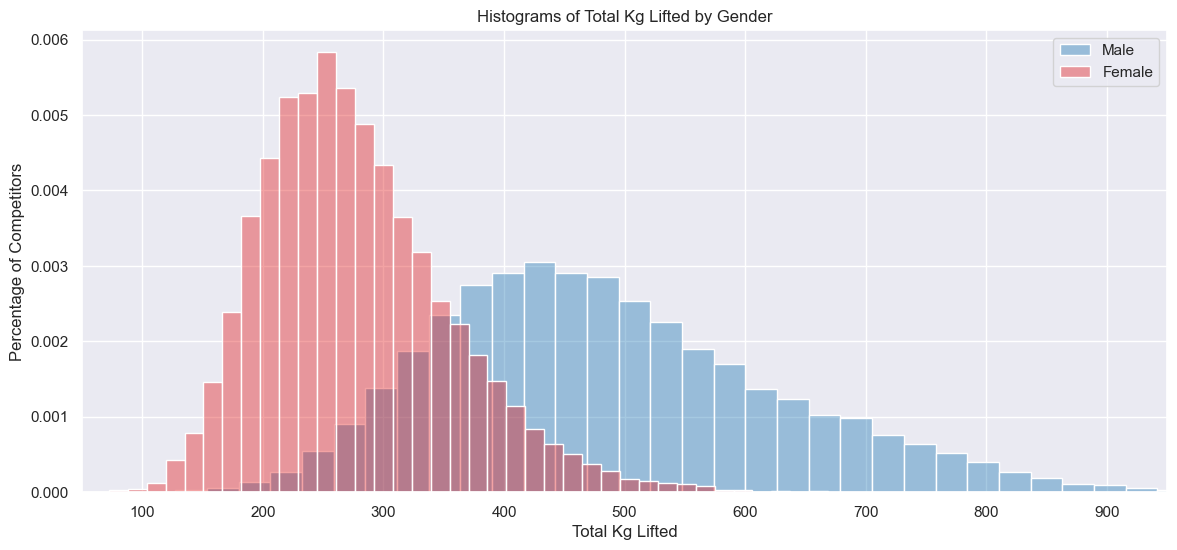

In [96]:
plt.close('all')
plt.figure(figsize = (14, 6))
sns.set()
# sns.set_context("notebook", font_scale = 1.1)

sns.histplot(males, label ='Male', stat='density', alpha=0.4, color = dblue,  bins=40)
sns.histplot(females, label ='Female', stat='density', alpha=0.4, color = dred,  bins=40)
plt.legend()

plt.title('Histograms of Total Kg Lifted by Gender')
#plt.yticks([])
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
plt.xlim(50, 950)
plt.xlabel('Total Kg Lifted')
plt.ylabel('Percentage of Competitors')
plt.show()

We utilise Scipy's `percentileofscore` function to evaluate what percentage of females powerlifters can be beat by the average male powerlifter and vice versa:

In [86]:
female_mean = females.mean()
male_mean = males.mean()

Mean_male_v_females = stats.percentileofscore(females, male_mean)
Mean_female_v_males = stats.percentileofscore(males, female_mean)
print(f'Average Female Total: {round(female_mean, 2)}kg')
print(f'Average Male Total: {round(male_mean, 2)}kg')
print()
print(f'The average male powerlifter is stronger than {round(Mean_male_v_females, 2)}% of female powerlifters.')
print(f'The average female powerlifter is stronger than {round(Mean_female_v_males, 2)}% of male powerlifters.')

Average Female Total: 277.32kg
Average Male Total: 485.5kg

The average male powerlifter is stronger than 98.58% of female powerlifters.
The average female powerlifter is stronger than 4.24% of male powerlifters.


In the above, we have compared the average male performance to the series of females and vice versa. Let us now formulate the problem in a more probabilistic manner to ascertain the strength of a male competitor **chosen at random** (i.e. not the average this time) compared to the series of females.

We achieve this using z-scores. In particular, we consider the distribution of the difference between the male and female lifts. Suppose that $M$ is a random variable following the distribution of total kg lifted by males, and $F$ similar for females. Then the random variable representing the difference in total kg lifted between males and females is given by $D = M - F$. We cannot simply subtract the two Series from each other for the value of $D$. However, we can compute the mean and the variance of $D$. For the former, $\mu_D = \mu_M - \mu_F$. For the latter, we have by the independence between the male and female data, we have that $\sigma_D^2$ = $\sigma_M^2$ + $\sigma_F^2$.

In [87]:
# find the mean of the difference distribution r.v.
diff_mean = males.mean() - females.mean()

# find the variance of the distribution r.v.
diff_var = males.std()**2 + females.std()**2
diff_std = np.sqrt(diff_var)

print(f"The average difference between male and female total weight lifted is {round(diff_mean, 2)}kg.")
print(f"The standard deviation of the difference is {round(diff_std, 2)}kg.")

The average difference between male and female total weight lifted is 208.19kg.
The standard deviation of the difference is 160.85kg.


We now model the distribution of the random variable $D$ as a Gaussian with the parameters above. Then if $D>0$, we have the case where the r.v. for the male exceeds the r.v. of the female and so the male has a higher total weight lifted. Conversely, if $D<0$, then the r.v. for the female is able to lift more.

0.0


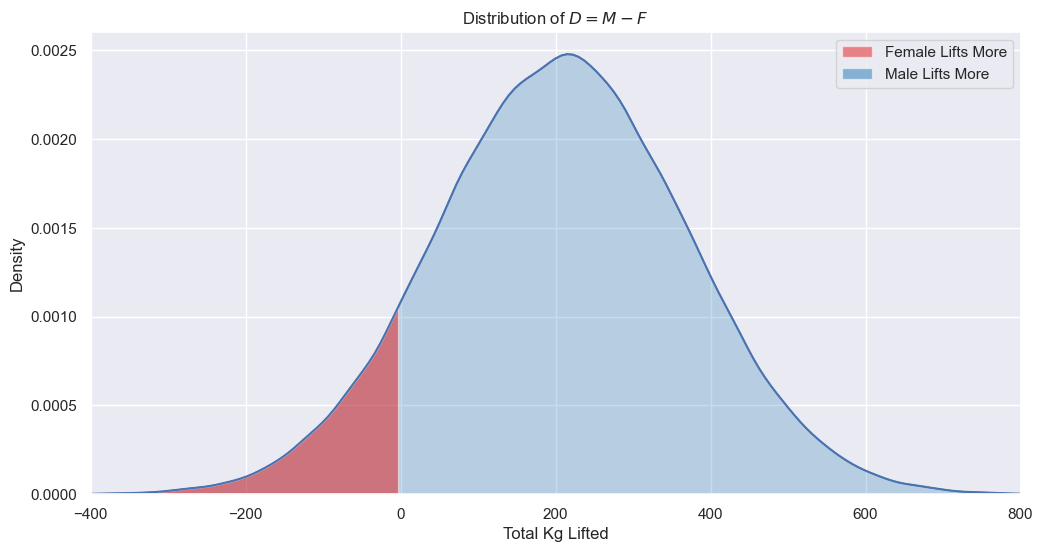

In [97]:
diff_dist = np.random.normal(diff_mean, diff_std, size=100000)
plt.figure(figsize = (12, 6))
sns.set()
# sns.set_context("notebook", font_scale = 1.1)

sns.kdeplot(diff_dist, color = dblue, fill = True)
# create an object to reference
ax = sns.kdeplot(diff_dist)
x, y = ax.get_lines()[-1].get_data()

# shading in female-dominant area using mask on kde
mask = x <= 0
x, y = x[mask], y[mask]
ax.fill_between(x, y1=y, alpha=0.5, facecolor= dred, label = 'Female Lifts More')

# shading in male-dominant area using mask on kde
mask = x > 0

# for later
x, y = x[mask], y[mask]
ax.fill_between(x, y1=y, alpha=0.5, facecolor= dblue, label = 'Male Lifts More')

plt.title('Distribution of $D = M - F$')
plt.legend()
plt.xlabel('Total Kg Lifted')

plt.xlim(-400, 800)

area = np.trapz(y, x)
print(area)

plt.show()


We can now evaluate the desired probability by using the z-score $z = \frac{X-\mu}{\sigma}$:

In [89]:
z = 0-diff_mean/diff_std
print(z)

-1.2943088309302144


In [90]:
p_female = stats.norm.cdf(z)
p_male = 1 - p_female

In [91]:
print("Selecting a male competitor and female competitor at random:")
print(f"The probability that the female is stronger than the male is: {round(p_female*100,2)}%.")
print(f"The probability that the male is stronger than the female is: {round(p_male*100,2)}%.")

Selecting a male competitor and female competitor at random:
The probability that the female is stronger than the male is: 9.78%.
The probability that the male is stronger than the female is: 90.22%.


The above investigation backs up scientific claims that men have more physical strength than women (due to biology, hormones, etc.).

### Wilks coefficient comparison

We now compare males and females using the Wilks formula.

In [92]:
males_wilks = df_filtered[df_filtered['Sex'] == 'M']['Wilks']
females_wilks = df_filtered[df_filtered['Sex'] == 'F']['Wilks']

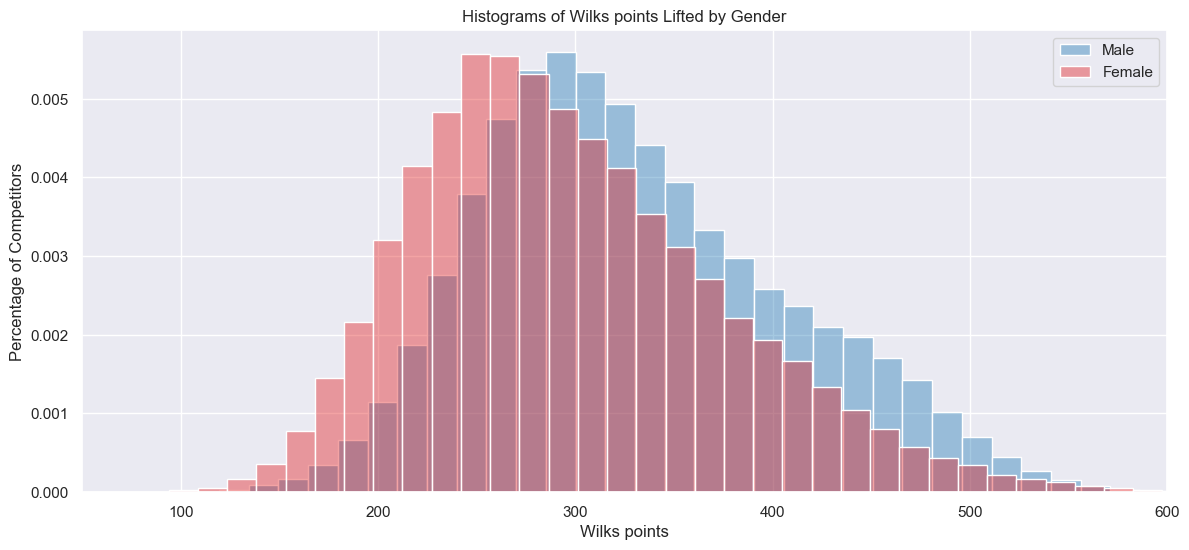

In [95]:
# histplot version (not deprecated)
plt.close('all')
plt.figure(figsize = (14, 6))
sns.set()
# sns.set_context("notebook", font_scale = 1.1)

sns.histplot(males_wilks, label ='Male', stat='density', alpha=0.4, color = dblue,  bins=40)
sns.histplot(females_wilks, label ='Female', stat='density', alpha=0.4, color = dred,  bins=40)
plt.legend()

plt.title('Histograms of Wilks points Lifted by Gender')
#plt.yticks([])
plt.xticks([0, 100, 200, 300, 400, 500, 600])
plt.xlim(50, 600)
plt.xlabel('Wilks points')
plt.ylabel('Percentage of Competitors')
plt.show()

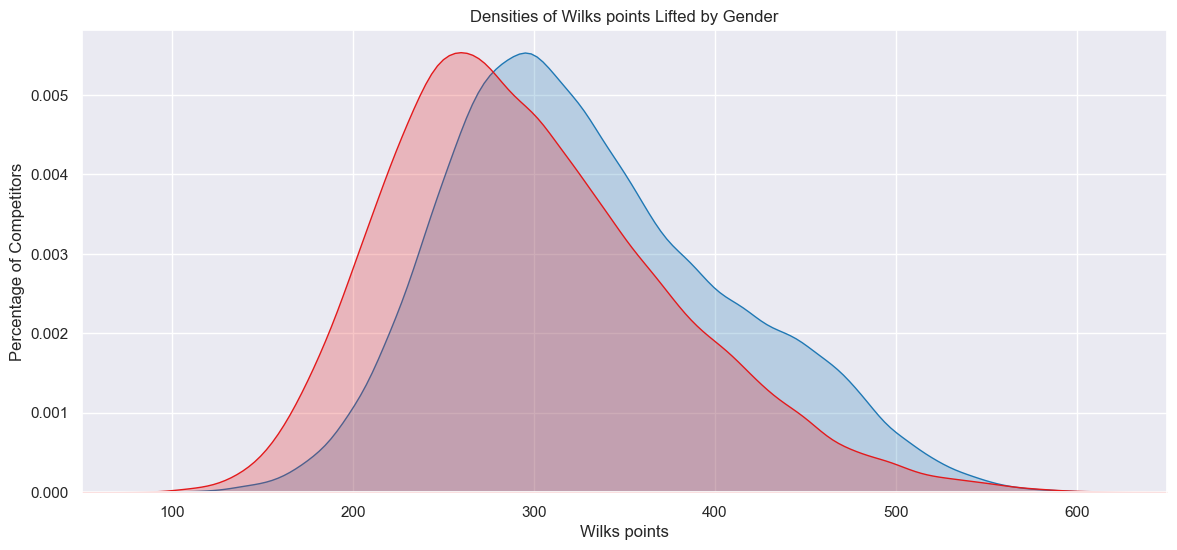

In [105]:
plt.figure(figsize = (14, 6))
sns.kdeplot(males_wilks, label='Natural', fill=True, color = dblue)
sns.kdeplot(females_wilks, label='Not tested', fill=True, color = dred)

plt.title('Densities of Wilks points Lifted by Gender')
#plt.yticks([])
plt.xticks([0, 100, 200, 300, 400, 500, 600])
plt.xlim(50, 650)
plt.xlabel('Wilks points')
plt.ylabel('Percentage of Competitors')
plt.show()

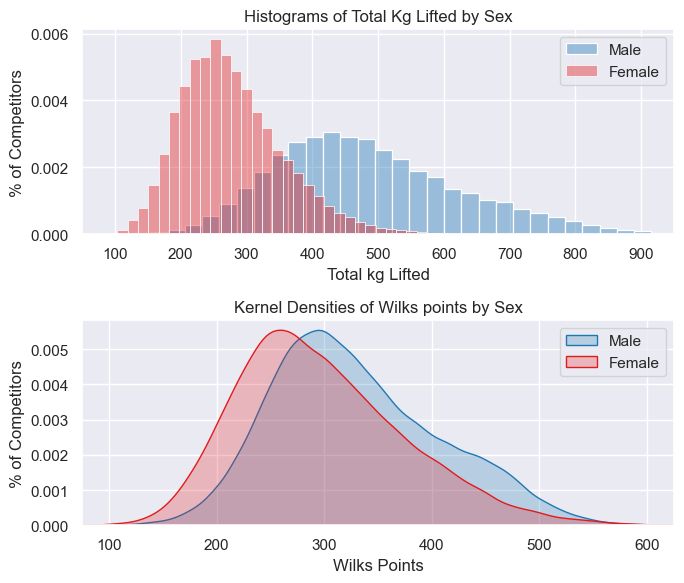

In [119]:
# subplots for report
sns.set()
fig, axes = plt.subplots(2, 1, figsize=(7, 6))
sns.histplot(males, label ='Male', stat='density', alpha=0.4, color = dblue,  bins=40, ax=axes[0])
sns.histplot(females, label ='Female', stat='density', alpha=0.4, color = dred,  bins=40, ax=axes[0])
axes[0].set_title('Histograms of Total Kg Lifted by Sex')
axes[0].set_xlabel('Total kg Lifted')
axes[0].set_ylabel('% of Competitors')
axes[0].set_xlim(50, 950)
axes[0].legend()


sns.kdeplot(males_wilks, label='Male', fill=True, color = dblue, ax=axes[1])
sns.kdeplot(females_wilks, label='Female', fill=True, color = dred, ax=axes[1])
axes[1].set_title('Kernel Densities of Wilks points by Sex')
axes[1].set_xlabel('Wilks Points')
axes[1].set_ylabel('% of Competitors')
axes[1].set_xlim(75, 625)
axes[1].legend()


plt.tight_layout()
plt.show()

## Natural or not?
---
Just because a lifter has not been tested for PED's, does not mean that they are using them. We can construct a hypothesis test to determine whether or not the distribution of `TotalKg` values is statistically different between the athletes who have been tested and those who have not. A significant difference implies that those are have not been tested are in fact abusing PEDs in competitions. Concretely:

$H_0$: lifters who have not been tested for PED use are natural athletes (i.e. are not using PEDs).

$H_A$: lifters who have not been tested for PED use are enhanced athletes (i.e. are using PEDs).


We can now compare the lifts between tested and untested athletes in the dataset. We compare males and females separately for the sake of clearer investigation. For clarity, we modify the values in the `Tested` column to `Natural` and `Not tested`. We restrict our study to `Single-ply` athletes.

In [32]:
df_test = df[['Name', 'Sex', 'Equipment', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 
               'TotalKg', 'Tested']]

In [33]:
# redoing data handling from previous section
df_test = df[['Name', 'Sex', 'Equipment', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 
               'TotalKg', 'Tested']]

df_test = df_test[df_test['Equipment'] == 'Single-ply']

# relabelling values in the `Tested` column
df_test['Tested'].fillna('Not tested', inplace = True)
df_test['Tested'].replace('Yes', 'Natural', inplace = True)

df_test = df_test.groupby(['Name','Sex',
                       'Tested'])[['Best3SquatKg','Best3BenchKg',
                       'Best3DeadliftKg','TotalKg','BodyweightKg']].mean().reset_index()

df_test['WeightClassKg'] = df_test['BodyweightKg'].apply(float)

# invoking the weight_class function from earlier    
df_test['WeightClassKg'] = df_test['BodyweightKg'].apply(lambda x: weight_class(x))

In [34]:
df_test.head()

,Name,Sex,Tested,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,BodyweightKg,WeightClassKg
0,A Abduzhabarov,M,Natural,155.00,110.00,170.00,435.00,74.00,070 - 80 kg
1,A Akins,M,Natural,115.67,90.72,129.27,335.66,107.05,100 - 110 kg
2,A Allmehat,M,Natural,165.00,120.00,170.00,455.00,72.50,070 - 80 kg
3,A Almeida,F,Natural,45.00,25.00,75.00,145.00,44.00,040 - 50 kg
4,A Ashwin,M,Natural,180.00,95.00,210.00,485.00,81.70,080 - 90 kg


In [35]:
df_test['Tested'].value_counts()

Tested
Natural       165690
Not tested     22116
Name: count, dtype: int64

In [36]:
len(df_test)

187806

We assess the cases of males and females separately:

In [37]:
df_males = df_test[df_test['Sex'] == 'M']
df_females = df_test[df_test['Sex'] == 'F']

In [38]:
males_nat = df_males[df_males['Tested'] == 'Natural']
males_enh = df_males[df_males['Tested'] == 'Not tested']

In [39]:
males_nat.head()

,Name,Sex,Tested,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,BodyweightKg,WeightClassKg
0,A Abduzhabarov,M,Natural,155.00,110.00,170.00,435.00,74.00,070 - 80 kg
1,A Akins,M,Natural,115.67,90.72,129.27,335.66,107.05,100 - 110 kg
2,A Allmehat,M,Natural,165.00,120.00,170.00,455.00,72.50,070 - 80 kg
4,A Ashwin,M,Natural,180.00,95.00,210.00,485.00,81.70,080 - 90 kg
5,A Bauer,M,Natural,145.00,90.00,150.00,385.00,51.70,050 - 60 kg


In [40]:
males_enh.head()

,Name,Sex,Tested,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,BodyweightKg,WeightClassKg
14,A Deshazo,M,Not tested,195.000,120.000,227.500,542.500,67.5,060 - 70 kg
19,A Edmonds,M,Not tested,163.290,129.270,188.240,480.810,67.5,060 - 70 kg
96,A. Acebo,M,Not tested,213.185,138.345,213.185,564.725,100.0,100 - 110 kg
97,A. Acquarelli,M,Not tested,147.500,147.500,190.000,485.000,82.5,080 - 90 kg
99,A. Adams,M,Not tested,150.000,130.000,195.000,475.000,140.0,130+ kg


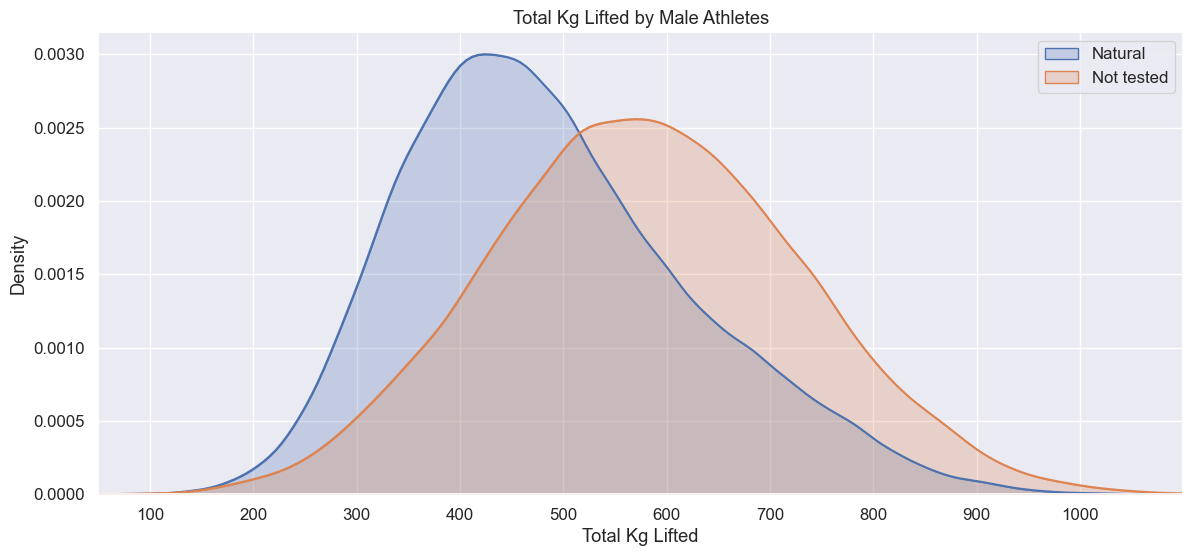

In [138]:
plt.close('all')
plt.figure(figsize = (14, 6))
sns.set_context("notebook", font_scale = 1.1)

sns.kdeplot(males_nat['TotalKg'], label='Natural', fill=True)
sns.kdeplot(males_enh['TotalKg'], label='Not tested', fill=True)

ax1 = sns.kdeplot(males_nat['TotalKg'])
x1_m, y1_m = ax1.get_lines()[-1].get_data()
ax2 = sns.kdeplot(males_enh['TotalKg'])
x2_m, y2_m = ax2.get_lines()[-1].get_data()

plt.title("Total Kg Lifted by Male Athletes")
plt.legend()
#plt.yticks([])
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.xlim(50, 1100)
plt.xlabel('Total Kg Lifted')
plt.ylabel('Density')
plt.show()

To compare these distributions, we employ a 2-sided Kolmogorov-Smirnov test, with a 5% significance level. Some notes on how the K-S test operates can be found <a href="https://www.statisticshowto.com/kolmogorov-smirnov-test/">here</a>.

In [42]:
males_ks_test = ks_2samp(y1_m, y2_m)
print(males_ks_test)

KstestResult(statistic=0.12, pvalue=0.11228360286766195, statistic_location=0.002558539979409032, statistic_sign=-1)


The K-S test yields a p-value larger than our significance level, so we do not reject the null hypothesis. Thus, we cannot determine the natual/enhanced status of male powerlifters.

We repeat the experiment for female powerlifters:

In [43]:
females_nat = df_females[df_females['Tested'] == 'Natural']
females_enh = df_females[df_females['Tested'] == 'Not tested']

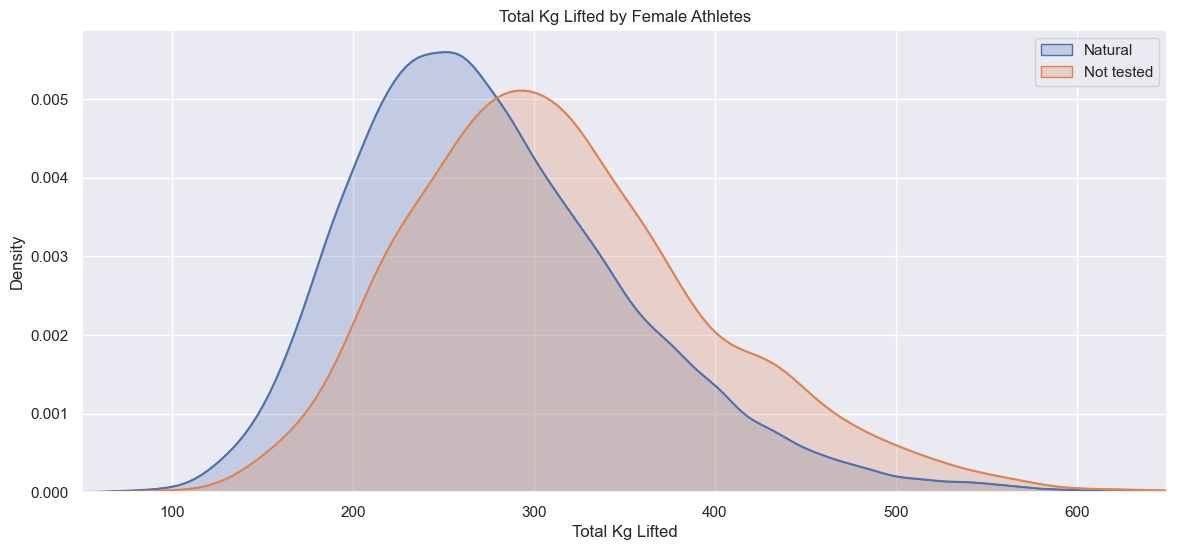

In [136]:
plt.close('all')
plt.figure(figsize = (14, 6))
sns.set()
# sns.set_context("notebook", font_scale = 1.1)

sns.kdeplot(females_nat['TotalKg'], label='Natural', fill=True)
sns.kdeplot(females_enh['TotalKg'], label='Not tested', fill=True)

ax1 = sns.kdeplot(females_nat['TotalKg'])
x1_f, y1_f = ax1.get_lines()[-1].get_data()
ax2 = sns.kdeplot(females_enh['TotalKg'])
x2_f, y2_f = ax2.get_lines()[-1].get_data()

plt.title("Total Kg Lifted by Female Athletes")
plt.legend()
#plt.yticks([])
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.xlim(50, 650)
plt.xlabel('Total Kg Lifted')
plt.ylabel('Density')
plt.show()

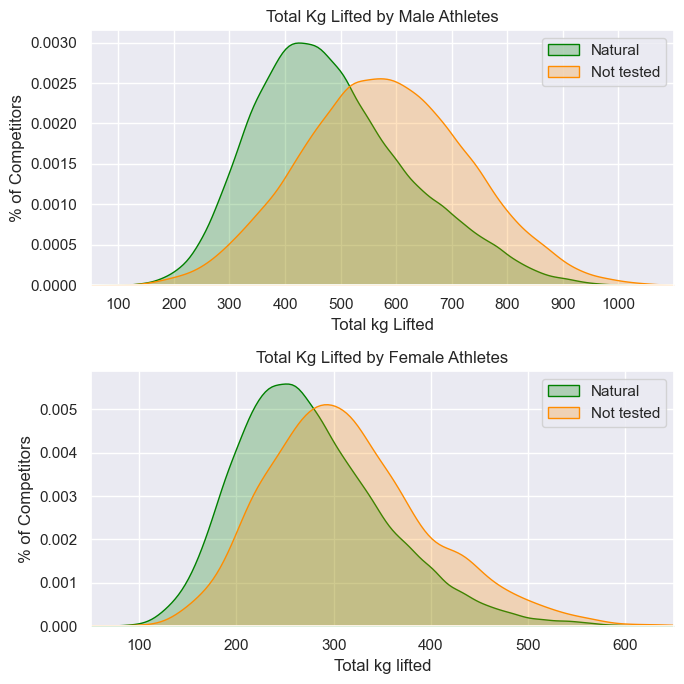

In [160]:
# subplots for report
sns.set()
fig, axes = plt.subplots(2, 1, figsize=(7, 7))
sns.kdeplot(males_nat['TotalKg'], label='Natural', fill=True, ax=axes[0], color='green')
sns.kdeplot(males_enh['TotalKg'], label='Not tested', fill=True, ax=axes[0], color='darkorange')
axes[0].set_title('Total Kg Lifted by Male Athletes')
axes[0].set_xlabel('Total kg Lifted')
axes[0].set_ylabel('% of Competitors')
axes[0].set_xlim(50, 1100)
axes[0].set_xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
axes[0].legend()


sns.kdeplot(females_nat['TotalKg'], label='Natural', fill=True, ax=axes[1], color='green')
sns.kdeplot(females_enh['TotalKg'], label='Not tested', fill=True, ax=axes[1], color='darkorange')
axes[1].set_title('Total Kg Lifted by Female Athletes')
axes[1].set_xlabel('Total kg lifted')
axes[1].set_ylabel('% of Competitors')
axes[1].set_xlim(50, 650)
#axes[1].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
axes[1].legend()


plt.tight_layout()
plt.show()

Now for the corresponding K-S test:

In [45]:
from scipy.stats import ks_2samp
ks_2samp(y1_f, y2_f)

KstestResult(statistic=0.08, pvalue=0.5452713464323318, statistic_location=0.0051052061750200845, statistic_sign=-1)

Although the distributions certainly look more similar in this case, we still cannot reject the null hypothesis as the p-value is greater than our significance level.

We conclude in either case that the natural status of untested athletes cannot be determined. 

## Q-Q plot

In [46]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

In [47]:
type(y1_m)

numpy.ndarray

<Figure size 800x600 with 0 Axes>

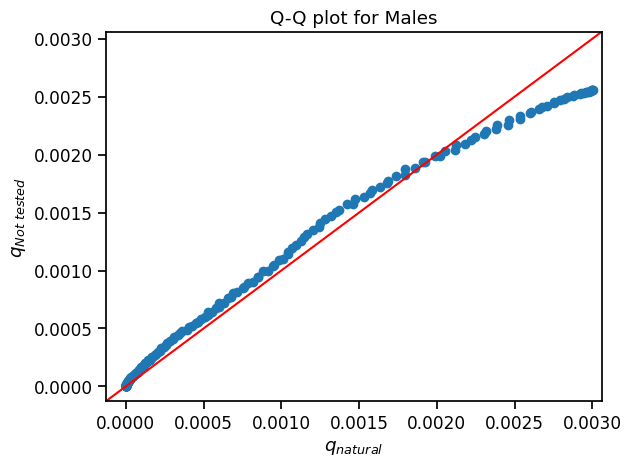

In [48]:
# qqplot_2samples(y1_m, y2_m)
plt.figure(figsize=(8, 6))
pp_x = sm.ProbPlot(y1_m)
pp_y = sm.ProbPlot(y2_m)
qqplot_2samples(pp_x, pp_y, xlabel='$q_{natural}$', ylabel='$q_{Not\ tested}$',line='45')
plt.title('Q-Q plot for Males')
plt.show()

<Figure size 800x600 with 0 Axes>

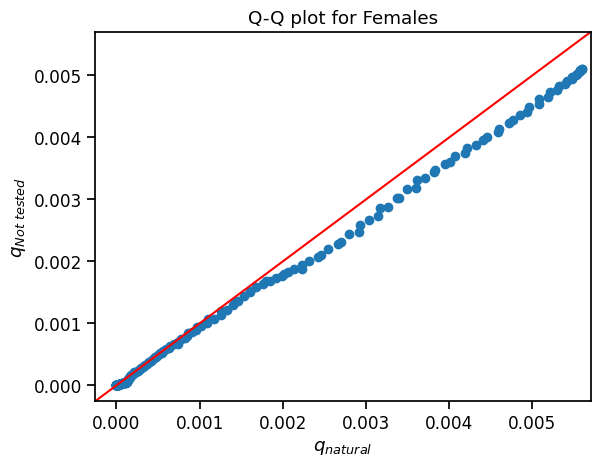

In [49]:
plt.figure(figsize=(8, 6))
pp_x = sm.ProbPlot(y1_f)
pp_y = sm.ProbPlot(y2_f)
qqplot_2samples(pp_x, pp_y, xlabel='$q_{natural}$', ylabel='$q_{Not\ tested}$',line='45')
plt.title('Q-Q plot for Females')
plt.show()

#### Subplot of Q-Q plots for clarity

AttributeError: 'Axes' object has no attribute 'qqplot_2samples'

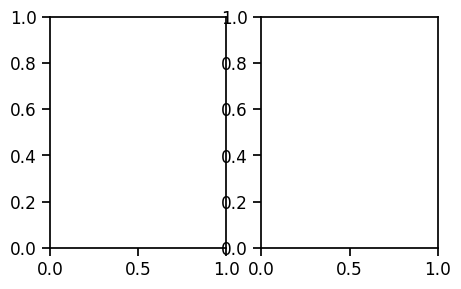

In [50]:
# fig, axs = plt.subplots(1, 2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

pp_x = sm.ProbPlot(y1_m)
pp_y = sm.ProbPlot(y2_m)

ax[0].qqplot_2samples(pp_x, pp_y, xlabel='Natural', ylabel='Not tested',line='45')
ax[1].qqplot_2samples(pp_x, pp_y, xlabel='Natural', ylabel='Not tested',line='45')
fig.tight_layout()



# plt.title('Q-Q plot for Males')
plt.show()